# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

# Новый раздел

In [ ]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
from dataset import TextDataset

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [ ]:
from model import LanguageModel

In [ ]:
model = LanguageModel(train_set)

In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [ ]:
from torch.utils.data import Dataset, DataLoader


BATCH_SIZE = 128

max_len = 0
with open('jokes.txt', 'r') as f:
    for line in f.readlines():
        max_len = max(max_len, len(line))

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=max_len)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=max_len)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

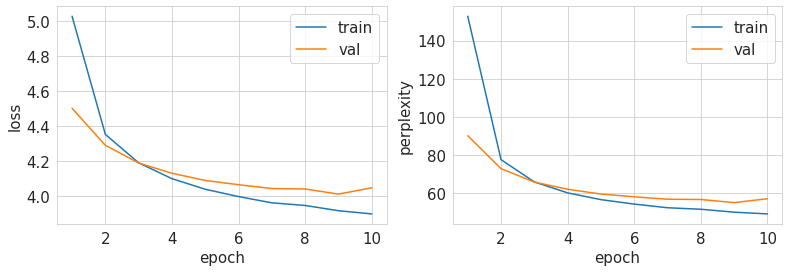

Generation examples:
- здравствуйте, а другая не умсела?- причина, наверное, мол, продавец. седь на мое молнию давать...- вот только на бутылке дамой свет. богда где он забрала ценить горобе на сами, но когда в генинештирлиц на пьянное бедное, вы вашинг портится.
если девушка делаешь все пациенту до  ⁇ 5 на одном свитер... а потом уже шесть месяцев духовных номера.
я позору сыну нужны впередное фигура.
во время смерти лукашенко, на сорок- нуле?- ну, хорошей. она был через двадцать тихо наташку. достаточно погуля и подорожал его за 10 запознанного. видит, что он фамился врач.
все бешенных дорожество салона, таня на полное платье? - такое суребузованное заяц? я родился 2000 буратима - я наклегу, гороскока - красивая, два года при желубабушки.


In [ ]:
from train import train


NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rnn_model = LanguageModel(train_set).to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3, weight_decay=1e-6)

train(rnn_model, optimizer, None, train_loader, valid_loader, NUM_EPOCHS)

In [ ]:
torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': rnn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, '/content/rnn.pt')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

**Сравнение:** За 10 эпох lstm обучилась чуть лучше, но субъективно rnn выдала что-то более приятное

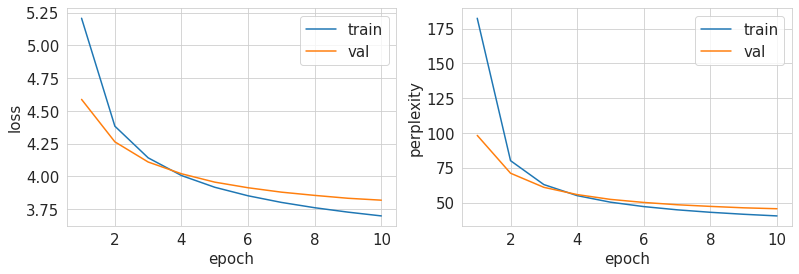

Generation examples:
- вчера он мне уже удало не когда целовал новый суровой сознание!отец- я вот думаю тебя мне кричалы?- не хотел уплатить ее осло деньги!- без проблем! вот с одной стороны слишком редкомы, с мафолку и в белья маслом обама.
она такая, - мало только радости ось.
галаглужаура десять стакан водки нет. - вы что будете сделать, что самое лучше?
пора уже переорать в одной новый мою девушку.
- в россии может  ⁇ 00 полу от парашляки больше всего не наказывало, любойный пригокрывая старух сто грамм и правда.


In [ ]:
lstm_model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3, weight_decay=1e-6)

train(lstm_model, optimizer, None, train_loader, valid_loader, NUM_EPOCHS)

In [ ]:
torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': lstm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, '/content/lstm.pt')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

**Выводы:** при маленьких значениях температуры (<= 0.1) модель часто повторяет одни и те же конструкции (например, 'я не могу'/ 'я не знаю' пару раз подряд в одном предложении), а при больших теряет способность выдавать адекватные слова

In [ ]:
temps = [0.01, 0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.5, 2., 10., 100.]
for t in temps:
    print(f'result for temperature {t}')
    print(lstm_model.inference(temp=t))
    print(rnn_model.inference(temp=t))
    print()

result for temperature 0.01
- а я вчера в школе у меня был такой жесткий, что я не могу понять, а я не могу понять, а я не могу понять, а я не могу.
- а я не могу понять, что у меня в голове, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а я не знаю, что ты не по-наугурацию, а не вкусный, а не вкусный, а я не

In [ ]:
t = 0.85
prefix = ['купил', 'купил мужик шляпу', 'в дверь', 'заходит в бар', '']
for p in prefix:
    print(f'result for prefix {p}')
    print(lstm_model.inference(prefix=p, temp=t))
    print(rnn_model.inference(prefix=p, temp=t))
    print()

result for prefix купил
купил фотографирует коньяку внезапно. на нечаялся и говорит вам сумку за яброс дядя, штирлиц его свалил раще и получает голый вопрос- абрам, а почему у тебя нет такой курт?- зайду до землю.
купил шарифы, что в растет статьи валерьянамки, и слышит пессимистов, в которой нет! обначали и говорит- ну, вот я станет.

result for prefix купил мужик шляпу
купил мужик шляпуй закупичную элитную балште. ползет, сильный пастушка и говорит- что ты делаешь?когда- давайте, да просто он бы не помню, жрочка, успокаиваю, ничего - это не пойду!
купил мужик шляпу звук на росковов турм?- несмотря в попозину.

result for prefix в дверь
в дверь с собой ходит к тому, что внутри - жена.
в дверь, когда люди от два темные уточнтов.

result for prefix заходит в бар
заходит в бар, решил тараканы, я приду.- покрел, сделаем тебе, сзади, чем не прокидали.
заходит в бар и съел его остановителем.

result for prefix 
- как ты думаешь, мне никто не пишет наскорызне?мок в одну неделю мысль... а он 

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

**Сравнение:** bpe был увелиичен в 10 раз, за 10 эпох начал немного переобучаться, до лосса маленького bpe не дошел, unigram аналогично, но вот текст генерируют они поприятнее

По perplexity  сравнивать не правильно, поскольку у нас разный размер словарей, а значит для подходящих токенов модель будет выдавать меньшую вероятность просто за счет большего количества токенов в словаре, что приведет к росту perplexity.


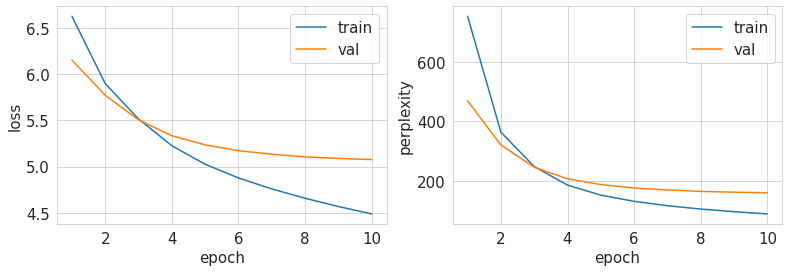

Generation examples:
чиновники слишком нравитьсятел. нашедни на россии, скрытой диктаторны срочно, а ведь только немцы изобрели московский дочки.
патриарх кирилл предупредил всем, как ты его не слышишь только его мой дед в тупик, другие руки уже не закроется на утренней...
я обои так не понял, что установленалайн - переросемость все, это и на загранпаспорт.
мой друг обидрил мои родители, а богатых заходите на землю.- ой, дорогая, вот это она. ну и что, ...
чтобы стать жизненным высоким статистике, что где вы работаете православные силы, любит, выразительные узнаете, не святая надежда, что от жены возникает...


In [ ]:
vocab_train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='big_bpe', vocab_size=20000, max_length=max_len)
vocab_valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='big_bpe', vocab_size=20000, max_length=max_len)

vocab_train_loader = DataLoader(vocab_train_set, batch_size=BATCH_SIZE, shuffle=True)
vocab_valid_loader = DataLoader(vocab_valid_set, batch_size=BATCH_SIZE, shuffle=True)

vocab_lstm_model = LanguageModel(vocab_train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(vocab_lstm_model.parameters(), lr=1e-3, weight_decay=1e-6)

train(vocab_lstm_model, optimizer, None, vocab_train_loader, vocab_valid_loader, NUM_EPOCHS)

In [ ]:
torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': vocab_lstm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, '/content/vocab_lstm.pt')

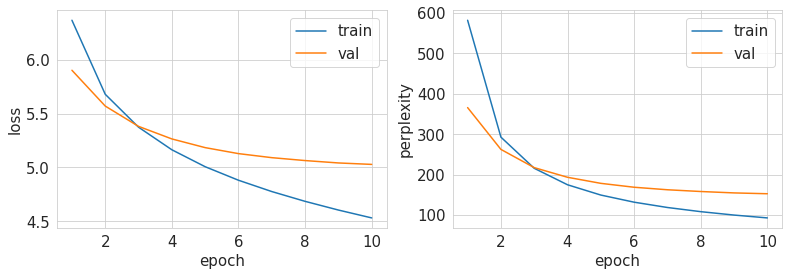

Generation examples:
следователь спрашивает у рабиновича-генерала-не, финансов, изжога - вам не оригинальное в сильные.- дорогой! до черного меня везде получается...
- вы встречаетесь на беленькие?- и я жить раз объясняю циел, сколько бы раз я разговариваю с мужем, убрался в торскучку, чтобы во лбу, как часы.
таких людей как  ⁇  американцев начинают продать машину, пока их иметь лучшей.
бабы в автобусе была в постели. пылесосы, особенно... чтобы больше - бесполезно! это еще на свете!
- почему ты грызешь?- за каком я знаю. тебе, именно любят каких-то проценты...


In [ ]:
uni_train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=20000, max_length=max_len, model_type='unigram')
uni_valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=20000, max_length=max_len, model_type='unigram')

uni_train_loader = DataLoader(uni_train_set, batch_size=BATCH_SIZE, shuffle=True)
uni_valid_loader = DataLoader(uni_valid_set, batch_size=BATCH_SIZE, shuffle=True)

uni_lstm_model = LanguageModel(uni_train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer = torch.optim.Adam(uni_lstm_model.parameters(), lr=1e-3, weight_decay=1e-6)

train(uni_lstm_model, optimizer, None, uni_train_loader, uni_valid_loader, NUM_EPOCHS)

In [ ]:
torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': uni_lstm_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, '/content/unigram_lstm.pt')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

плюсы:
- за счет понижения размерности может получиться убрать 'шум' из данных
- переводим все слова и сгенерированные анекдоты в одно пространство, за счет чего образовываются кластеры
- смотрит более глобально на все сгенерированные тексты

минусы
- долго вычисляется за счет svd
- хранение сгенерированных векторов занимает много места


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def LSA(model, valid_set):
    generated_set = [model.inference() for _ in range(len(valid_set))]
    enc_valid_set = [valid_set.ids2text(valid_set[i][0]) for i in range(len(valid_set))]
    corp = generated_set + enc_valid_set
    tf_idf = TfidfVectorizer().fit_transform(corp)
    truncated = TruncatedSVD(100).fit_transform(tf_idf)
    cos_sim = cosine_similarity(truncated[:len(valid_set)], truncated[len(valid_set):])
    return cos_sim.max(axis=0).mean(), generated_set, truncated

In [ ]:
score, gen_basic_bpe, basic_bpe = LSA(lstm_model, valid_set)
print(f'lstm model, bpe, 2000 vocab: {score:.5f}')

score, gen_vocab_bpe, vocab_bpe = LSA(vocab_lstm_model, vocab_valid_set)
print(f'lstm model, bpe, 20000 vocab: {score:.5f}')

score, gen_uni, uni = LSA(uni_lstm_model, uni_valid_set)
print(f'lstm model, unigram, 20000 vocab: {score:.5f}')

lstm model, bpe, 2000 vocab: 0.73277
lstm model, bpe, 20000 vocab: 0.73561
lstm model, unigram, 20000 vocab: 0.73945


## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [ ]:
from sklearn.manifold import TSNE


tsne_basic = TSNE(init='pca', learning_rate='auto').fit_transform(basic_bpe)
tsne_vocab = TSNE(init='pca', learning_rate='auto').fit_transform(vocab_bpe)
tsne_uni = TSNE(init='pca', learning_rate='auto').fit_transform(uni)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


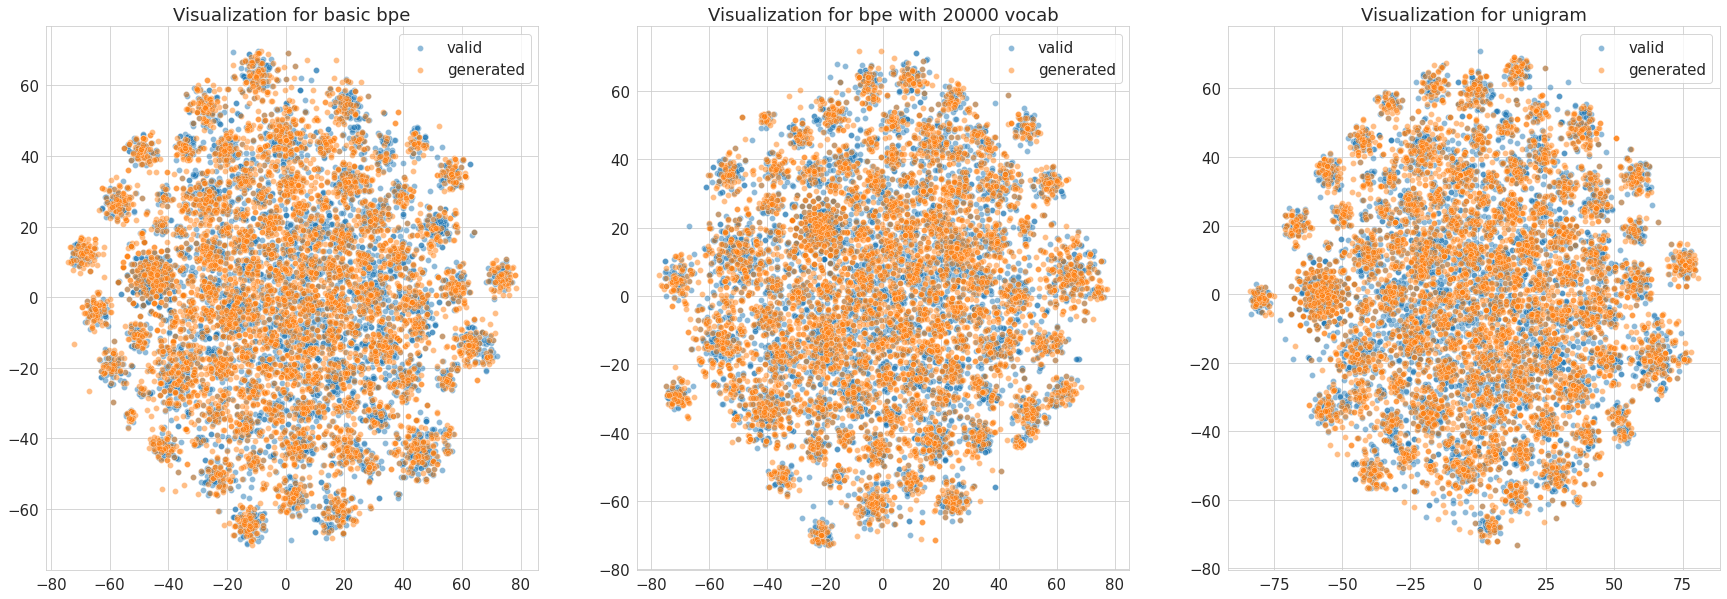

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.scatterplot(x=tsne_basic[len(valid_set):, 0], y=tsne_basic[len(valid_set):, 1], alpha=0.5, ax=ax[0], label='valid')
sns.scatterplot(x=tsne_basic[:len(valid_set), 0], y=tsne_basic[:len(valid_set), 1], alpha=0.5, ax=ax[0], label='generated')
ax[0].set_title('Visualization for basic bpe')

sns.scatterplot(x=tsne_vocab[len(valid_set):, 0], y=tsne_vocab[len(valid_set):, 1], alpha=0.5, ax=ax[1], label='valid')
sns.scatterplot(x=tsne_vocab[:len(valid_set), 0], y=tsne_vocab[:len(valid_set), 1], alpha=0.5, ax=ax[1], label='generated')
ax[1].set_title('Visualization for bpe with 20000 vocab')

sns.scatterplot(x=tsne_uni[len(valid_set):, 0], y=tsne_uni[len(valid_set):, 1], alpha=0.5, ax=ax[2], label='valid')
sns.scatterplot(x=tsne_uni[:len(valid_set), 0], y=tsne_uni[:len(valid_set), 1], alpha=0.5, ax=ax[2], label='generated')
ax[2].set_title('Visualization for unigram')

plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
!pip install huggingface transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.6 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM


def gpt_ppl(gen_set):
    tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
    model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)
    encodings = tokenizer("\n\n".join(gen_set), return_tensors="pt")

    max_length = model.config.n_positions
    stride = 100
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl.item()

In [ ]:
print(f'lstm model, bpe, 2000 vocab: {gpt_ppl(gen_basic_bpe):.5f}')
print(f'lstm model, bpe, 20000 vocab: {gpt_ppl(gen_vocab_bpe):.5f}')
print(f'lstm model, unigram, 20000 vocab: {gpt_ppl(gen_uni):.5f}')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 99%|█████████▉| 1804/1824 [07:55<00:05,  3.79it/s]


lstm model, bpe, 2000 vocab: 546.84680


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 99%|█████████▉| 1779/1799 [07:49<00:05,  3.79it/s]


lstm model, bpe, 20000 vocab: 370.66547


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 99%|█████████▉| 1724/1744 [07:34<00:05,  3.79it/s]

lstm model, unigram, 20000 vocab: 348.00415


bpe c 2000 показал худший результат, bpe 20000 лучше почти на 200, а unigram не так сильно отличается от большого bpe, всего на 20

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.


в мужской компании - редкий момент молодежь задумалась - не пейте.